In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 0)

import pickle
import sys
import os
import json

if ".." not in sys.path:
    sys.path.append("..")
    
from typing import Dict, Tuple, Sequence, List

import matplotlib.pyplot as plt

In [2]:
from pp5 import OUT_DIR

PVAL_THRESH = 1.0

PREC_OUT_DIR = OUT_DIR.joinpath("prec-collected")
RESULTS_TAG = "pointwise_cdist-t_2-bs_200-n_1-k_500"
# RESULTS_TAG = "pointwise_cdist-tmp"
INTERMEDIATE_DIR = "_intermediate_"

DATASET_DIRS = (
    PREC_OUT_DIR.joinpath("20210102_115634-aida-ex_EC-src_EC-r18"),
#     PREC_OUT_DIR.joinpath("20210102_112030-aida-ex_EC-src_HS-r18"),
#     PREC_OUT_DIR.joinpath("20210102_112750-aida-ex_EC-src_ALL-r18"),
#     PREC_OUT_DIR.joinpath("20210505_131701-photon"),
)


### Dataset stats

In [3]:
from pp5.analysis import DSSP_TO_SS_TYPE

# Maps from dataset tag to a metadata dict
datasets_meta = {}

# Maps from dataset tag to the group_sizes dict from results meta.json
datasets_group_sizes: Dict[str, dict] = {}

# Maps from dataset tag to it's path
dataset_result_dirs: Dict[str, Path] = {}

for i, ds_dir in enumerate(DATASET_DIRS):
    # Load dataset metadata
    meta_path = ds_dir.joinpath("meta.json")
    with open(meta_path, "r") as f:
        ds_meta = json.load(f)
    for _col in ("steps","async_timeout","create_zip"):
        ds_meta.pop(_col)
    tag = ds_meta.pop("out_tag") or f"ds_{i:02d}"
    
    
    # Load results metadata
    results_meta_path = ds_dir.joinpath("results", RESULTS_TAG, "meta.json")
    with open(results_meta_path, "r") as f:
        results_meta = json.load(f)

    # Copy some stats over from the results meta
    for group, group_meta in results_meta["group_sizes"].items():
        ds_meta[f"n_{group}"] = group_meta["total"]
    for _col in ("codon_tuple_len", "min_group_size", "t2_n_max", "t2_permutations"):
        ds_meta[_col] = results_meta[_col]
        
    # Save all group sizes
    datasets_group_sizes[tag] = results_meta["group_sizes"]
        
    # Load data
    data_prec_path = ds_dir.joinpath("data-precs.csv")
    df_pointwise = pd.read_csv(
        data_prec_path,
        usecols=("pdb_id", "res_id", "unp_id", "unp_idx", "codon", "secondary"),
        dtype={"unp_idx": "Int64"},
        header=0,
        # Consolidate different SS types into the ones we support
        converters={"secondary": lambda ss: DSSP_TO_SS_TYPE.get(ss, "")},
    )
    
    # Save some stats
    ds_meta["n_PDB_structs"] = len(df_pointwise.pdb_id.unique())
    ds_meta["n_UNP_records"] = len(df_pointwise.unp_id.unique())
    
    dataset_result_dirs[tag] = ds_dir.joinpath("results", RESULTS_TAG, INTERMEDIATE_DIR)
    assert dataset_result_dirs[tag].is_dir()
    datasets_meta[tag] = ds_meta
    
    ############
    # break


/Users/aviv/miniconda3/envs/proteins/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_datasets_meta = pd.DataFrame(datasets_meta)
df_datasets_meta.to_csv(f"out/pointwise_dataset_stats.csv", float_format="%.3f")
df_datasets_meta

,ex_EC-src_EC
codon_tuple_len,2
dataset_size_mb,35.62
hostname,aida
id,20210102_115634-aida-ex_EC-src_EC
min_group_size,1
n_HELIX,48546
n_MIXED,16546
n_OTHER,10494
n_PDB_structs,1963
n_SHEET,28282


In [5]:
len(df_pointwise.pdb_id.unique()),  len(df_pointwise.unp_id.unique())

(1963, 680)

## Helper Functions

In [6]:
def load_results(
    dataset_result_dirs: Dict[str, Path], result_names: Sequence[str]
) -> Dict[str, Sequence[Dict]]:
    
    # maps dataset tag -> [results_dict1, results_dict2, ...]
    dataset_loaded_results: Dict[str, Sequence[Dict]] = {}

    for ds_tag, ds_dir in dataset_result_dirs.items():

        loaded_results = []

        for result_name in result_names:

            result_path = ds_dir.joinpath(result_name)
            assert result_path.is_file(), f"{ds_tag=} {result_name=}"

            with open(result_path, 'rb') as f:
                p = pickle.load(f)
                # remove the length-1 array
                # p = {k: v[0] for k,v in p.items()}

            loaded_results.append(p)

        dataset_loaded_results[ds_tag] = loaded_results
    
    return dataset_loaded_results

In [7]:
import itertools as it

csv_float_fmt = "%.5f"

def results_to_df(
    results: Dict[Tuple, Dict],
    index_col_names: Sequence[str],
    sort_by: Sequence[str] = (),
    split_cols: Sequence[str] = (),
    split_cols_delim: str = "_",
    write_csv: str=None,
):
    
    index = [k for k, v in results.items() for _ in v]
    index = pd.MultiIndex.from_tuples(index, names=index_col_names)
    
    data = it.chain(*results.values())
    df = pd.DataFrame(data=data, index=index)
    
    # Sort: always sort by index colums, and then by additional sort columns
    df = df.sort_values(by=[*index_col_names, *sort_by])
    
    # Split columns based on delimiter
    for col in split_cols:
        split_cols = df[col].str.split(split_cols_delim, -1, expand=True)
        split_cols.columns = [f"{col}.{i+1}" for i in split_cols.columns]
        df = pd.concat([df, split_cols], axis=1)
    
    if write_csv:
        df.to_csv(write_csv, float_format=csv_float_fmt)

    return df
    

### Codon vs. Codon

In [8]:
CODON_DIHEDRAL_PVALS = "codon-dihedral-pvals.pkl"
CODON_DIHEDRAL_T2S = "codon-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_codon_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[CODON_DIHEDRAL_PVALS, CODON_DIHEDRAL_T2S]
)

In [9]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP

# Assuming all results have the same tuple length
tuple_len = ds_meta["codon_tuple_len"]


SYN_TUPLES_IDX = sorted(aac_index_pairs(k=tuple_len, synonymous=True, unique=True))
SYN_TUPLES_IDX = np.array(SYN_TUPLES_IDX)

AAC_TUPLES = [str.join(AAC_TUPLE_SEP, (a1, a2)) for (a1, a2) in aac_tuples(k=2)]

print(f'{len(SYN_TUPLES_IDX)=}, {len(AAC_TUPLES)=}')

len(SYN_TUPLES_IDX)=29473, len(AAC_TUPLES)=3721


In [10]:

results_cc = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_codon_dists.items():
    
    assert ds_pvals.keys() == ds_t2s.keys()
    
    for ss_type in ds_pvals.keys():
        
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]
        
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
        
        syn_codon_pvals = ds_ss_pvals[tuple(zip(*SYN_TUPLES_IDX))]
        syn_significant_idx_flat = syn_codon_pvals <= PVAL_THRESH
        syn_significant_idx = SYN_TUPLES_IDX[syn_significant_idx_flat]
        
        results_cc[(ds_tag,ss_type)] = [
            {
                "tuple1": AAC_TUPLES[aac1],
                "tuple2": AAC_TUPLES[aac2],
                "n1": ds_ss_subgroup_sizes[AAC_TUPLES[aac1]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[aac2]],
                "pval": ds_ss_pvals[aac1, aac2],
                "t2": ds_ss_t2[aac1, aac2],
            }
            for aac1, aac2 in syn_significant_idx
        ]

In [11]:
index_col_names = ["Dataset", "SS"]

df_pvals_cc = results_to_df(
    results_cc,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_cc-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_cc

tuple1       tuple2  n1   n2  pval            t2  \
Dataset      SS                                                             
ex_EC-src_EC HELIX  A-GCA_S-TCA  A-GCT_S-TCC  8   16   0.0   8.369699e+00   
             HELIX  A-GCC_A-GCA  A-GCC_A-GCG  63  83   0.0   9.425907e+00   
             HELIX  A-GCC_A-GCC  A-GCG_A-GCG  95  206  0.0   6.845419e+00   
             HELIX  A-GCC_A-GCG  A-GCG_A-GCG  83  206  0.0   1.533236e+01   
             HELIX  A-GCC_H-CAT  A-GCG_H-CAT  16  27   0.0   8.506213e+00   
             HELIX  A-GCC_M-ATG  A-GCG_M-ATG  49  119  0.0   1.268856e+01   
             HELIX  A-GCG_R-CGC  A-GCT_R-CGA  67  2    0.0   4.976157e+01   
             HELIX  A-GCG_V-GTG  A-GCT_V-GTG  99  17   0.0   1.320798e+01   
             HELIX  A-GCT_S-TCC  A-GCT_S-TCT  16  14   0.0   6.773734e+00   
             HELIX  D-GAC_D-GAC  D-GAC_D-GAT  15  30   0.0   8.568162e+00   
             HELIX  D-GAC_D-GAC  D-GAT_D-GAT  15  37   0.0   5.135460e+00   
             HELIX  E-GAA_S-TCG  E-GAG_S-TCC  14  10   0.0   8.178958e+00   
             HELIX  E-GAA_S-TCT  E-GAG_S-TCC  11  10   0.0   1.483052e+01   
             HELIX  E-GAG_N-AAC  E-GAG_N-AAT  15  7    0.0   5.444132e+00   
             HELIX  E-GAG_S-TCC  E-GAG_S-TCG  10  8    0.0   1.200192e+01   
             HELIX  G-GGA_G-GGC  G-GGC_G-GGC  10  20   0.0   7.125847e+00   
             HELIX  G-GGA_G-GGC  G-GGC_G-GGG  10  5    0.0   9.557508e+00   
             HELIX  G-GGA_G-GGC  G-GGC_G-GGT  10  12   0.0   2.314914e+01   
             HELIX  G-GGA_G-GGC  G-GGT_G-GGC  10  11   0.0   6.063019e+00   
             HELIX  G-GGA_G-GGC  G-GGT_G-GGT  10  4    0.0   4.694046e+01   
             HELIX  G-GGA_R-CGG  G-GGT_R-CGC  3   10   0.0   9.036107e+00   
             HELIX  G-GGC_A-GCA  G-GGG_A-GCG  32  18   0.0   6.824400e+00   
...                         ...          ... ..   ..   ...            ...   
             TURN   W-TGG_A-GCG  W-TGG_A-GCG  2   2    1.0   0.000000e+00   
             TURN   W-TGG_E-GAA  W-TGG_E-GAA  2   2    1.0   0.000000e+00   
             TURN   W-TGG_F-TTT  W-TGG_F-TTT  3   3    1.0   0.000000e+00   
             TURN   W-TGG_G-GGG  W-TGG_G-GGG  2   2    1.0   0.000000e+00   
             TURN   W-TGG_H-CAT  W-TGG_H-CAT  2   2    1.0   0.000000e+00   
             TURN   W-TGG_L-CTG  W-TGG_L-CTG  2   2    1.0   0.000000e+00   
             TURN   W-TGG_Q-CAG  W-TGG_Q-CAG  2   2    1.0   0.000000e+00   
             TURN   W-TGG_R-CGC  W-TGG_R-CGC  2   2    1.0   0.000000e+00   
             TURN   Y-TAC_D-GAC  Y-TAC_D-GAC  3   3    1.0   1.438290e-15   
             TURN   Y-TAC_F-TTT  Y-TAC_F-TTT  2   2    1.0   0.000000e+00   
             TURN   Y-TAC_G-GGT  Y-TAC_G-GGT  13  13   1.0  -2.213170e-14   
             TURN   Y-TAC_H-CAT  Y-TAC_H-CAT  2   2    1.0   0.000000e+00   
             TURN   Y-TAC_N-AAC  Y-TAC_N-AAC  4   4    1.0  -3.772465e-15   
             TURN   Y-TAC_N-AAT  Y-TAC_N-AAT  2   2    1.0  -3.739906e-16   
             TURN   Y-TAC_R-CGC  Y-TAC_R-CGC  3   3    1.0   0.000000e+00   
             TURN   Y-TAC_T-ACC  Y-TAC_T-ACC  2   2    1.0   0.000000e+00   
             TURN   Y-TAC_W-TGG  Y-TAC_W-TGG  4   4    1.0  -4.177414e-15   
             TURN   Y-TAT_A-GCA  Y-TAT_A-GCA  2   2    1.0   0.000000e+00   
             TURN   Y-TAT_A-GCC  Y-TAT_A-GCC  2   2    1.0   0.000000e+00   
             TURN   Y-TAT_G-GGA  Y-TAT_G-GGA  3   3    1.0   6.291795e-16   
             TURN   Y-TAT_H-CAC  Y-TAT_H-CAC  2   2    1.0   0.000000e+00   
             TURN   Y-TAT_L-CTC  Y-TAT_L-CTC  2   2    1.0   0.000000e+00   

                   tuple1.1 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                                         
ex_EC-src_EC HELIX  A-GCA    S-TCA    A-GCT    S-TCC    
             HELIX  A-GCC    A-GCA    A-GCC    A-GCG    
             HELIX  A-GCC    A-GCC    A-GCG    A-GCG    
             HELIX  A-GCC    A-GCG    A-GCG    A-GCG    
             HELIX  A-GCC    H-CAT    A-GCG    H-CAT    
      

### AA vs. AA

In [12]:
AA_DIHEDRAL_PVALS = "aa-dihedral-pvals.pkl"
AA_DIHEDRAL_T2S = "aa-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aa_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[AA_DIHEDRAL_PVALS, AA_DIHEDRAL_T2S]
)

In [13]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP


AA_TUPLES = [str.join(AAC_TUPLE_SEP, (a1[0], a2[0])) for (a1, a2) in aac_tuples(k=2)]
AA_TUPLES = sorted(set(AA_TUPLES))
print(f"{len(AA_TUPLES)=}")

len(AA_TUPLES)=400


In [14]:
results_aa = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aa_dists.items():
    
    assert ds_pvals.keys() == ds_t2s.keys()
    
    for ss_type in ds_pvals.keys():
        
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]
        
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
        
        # Temp hack: remove redundant entries because for some reason they were calcualted
        ds_ss_pvals[np.tril_indices_from(ds_ss_pvals, k=-1)]=np.nan
        
        # [(aa1, aa2), (aa3, aa4), ...]
        aa_significant_idx = list(zip(
            # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
            *np.where(ds_ss_pvals <= PVAL_THRESH)
        ))
        
        results_aa[(ds_tag,ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa1],
                "tuple2": AA_TUPLES[aa2],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa1]],
                "n2": ds_ss_subgroup_sizes[AA_TUPLES[aa2]],
                "pval": ds_ss_pvals[aa1, aa2],
                "t2": ds_ss_t2[aa1, aa2]
            }
            for aa1, aa2 in aa_significant_idx
        ]
        
        print(f"{ss_type}: {len(aa_significant_idx)=}")

HELIX: len(aa_significant_idx)=79800
MIXED: len(aa_significant_idx)=78210
OTHER: len(aa_significant_idx)=77028
SHEET: len(aa_significant_idx)=80200
TURN: len(aa_significant_idx)=67161


In [15]:

df_pvals_aa = results_to_df(
    results_aa,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_aa-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_aa

tuple1 tuple2    n1   n2  pval            t2 tuple1.1  \
Dataset      SS                                                            
ex_EC-src_EC HELIX  A_A    A_L    1021  962  0.0   1.411199e+01  A         
             HELIX  A_A    A_P    1021  52   0.0   6.367788e+01  A         
             HELIX  A_A    D_K    1021  146  0.0   1.989629e+01  A         
             HELIX  A_A    E_P    1021  28   0.0   3.944391e+01  A         
             HELIX  A_A    E_Q    1021  319  0.0   1.225667e+01  A         
             HELIX  A_A    F_A    1021  236  0.0   1.242410e+01  A         
             HELIX  A_A    F_D    1021  105  0.0   1.734497e+01  A         
             HELIX  A_A    F_I    1021  117  0.0   9.692724e+00  A         
             HELIX  A_A    F_L    1021  197  0.0   1.203463e+01  A         
             HELIX  A_A    F_P    1021  19   0.0   3.730105e+01  A         
             HELIX  A_A    G_L    1021  241  0.0   6.595594e+00  A         
             HELIX  A_A    G_P    1021  34   0.0   1.825182e+01  A         
             HELIX  A_A    I_A    1021  473  0.0   7.351218e+01  A         
             HELIX  A_A    I_D    1021  187  0.0   5.025188e+01  A         
             HELIX  A_A    I_E    1021  247  0.0   2.633917e+01  A         
             HELIX  A_A    I_G    1021  137  0.0   1.933535e+01  A         
             HELIX  A_A    I_I    1021  176  0.0   3.167170e+01  A         
             HELIX  A_A    I_K    1021  162  0.0   2.884173e+01  A         
             HELIX  A_A    I_L    1021  274  0.0   3.674005e+01  A         
             HELIX  A_A    I_N    1021  154  0.0   2.712640e+01  A         
             HELIX  A_A    I_P    1021  43   0.0   8.314323e+01  A         
             HELIX  A_A    I_R    1021  212  0.0   5.505556e+01  A         
...                 ...    ...     ...  ..   ...            ... ..         
             TURN   V_I    V_I    4     4    1.0  -4.353308e-15  V         
             TURN   V_K    V_K    8     8    1.0  -7.727883e-15  V         
             TURN   V_M    V_M    4     4    1.0   0.000000e+00  V         
             TURN   V_T    V_T    16    16   1.0   3.613676e-15  V         
             TURN   W_E    W_E    2     2    1.0   0.000000e+00  W         
             TURN   W_F    W_F    4     4    1.0   0.000000e+00  W         
             TURN   W_G    W_G    13    13   1.0   1.316584e-14  W         
             TURN   W_H    W_H    2     2    1.0   0.000000e+00  W         
             TURN   W_H    W_Y    2     2    1.0   1.176275e-01  W         
             TURN   W_H    Y_T    2     5    1.0   4.763404e-02  W         
             TURN   W_L    W_L    3     3    1.0  -1.504247e-15  W         
             TURN   W_Q    W_Q    2     2    1.0   0.000000e+00  W         
             TURN   W_Y    W_Y    2     2    1.0   0.000000e+00  W         
             TURN   W_Y    Y_F    2     4    1.0   2.128919e-01  W         
             TURN   Y_A    Y_A    18    18   1.0  -3.808605e-15  Y         
             TURN   Y_E    Y_E    12    12   1.0  -4.417175e-14  Y         
             TURN   Y_F    Y_F    4     4    1.0   0.000000e+00  Y         
             TURN   Y_I    Y_I    2     2    1.0   0.000000e+00  Y         
             TURN   Y_I    Y_W    2     4    1.0   3.182688e-02  Y         
             TURN   Y_L    Y_L    13    13   1.0   5.587182e-14  Y         
             TURN   Y_N    Y_N    12    12   1.0  -8.866333e-15  Y         
             TURN   Y_W    Y_W    4     4    1.0  -4.177414e-15  Y         

                   tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                                
ex_EC-src_EC HELIX  A        A        L        
             HELIX  A        A        P        
             HELIX  A        D        K        
             HELIX  A        E        P        
             HELIX  A        E        Q        
             HELIX  A        F        A        
             HELIX  A        F        D        
             H

In [16]:
# Filter out G & P
filter_pattern = "[^GP]_[^GP]"
idx = pd.Series([True]*len(df_pvals_aa),index=df_pvals_aa.index)
print(sum(idx))
for col in ('tuple1', 'tuple2'):
    idx &= df_pvals_aa[col].str.fullmatch(filter_pattern)
    print(sum(idx))
    
df_pvals_aa_filtered = df_pvals_aa[idx]
df_pvals_aa_filtered = df_pvals_aa_filtered.sort_values(by=[*index_col_names,"pval"])
df_pvals_aa_filtered.to_csv(f"out/pointwise_pvals_aa-{PVAL_THRESH}-filtered.csv", float_format=csv_float_fmt)
df_pvals_aa_filtered

382399
305140
249225


tuple1 tuple2    n1   n2  pval            t2 tuple1.1  \
Dataset      SS                                                            
ex_EC-src_EC HELIX  A_A    A_L    1021  962  0.0   1.411199e+01  A         
             HELIX  A_A    D_K    1021  146  0.0   1.989629e+01  A         
             HELIX  A_A    E_Q    1021  319  0.0   1.225667e+01  A         
             HELIX  A_A    F_A    1021  236  0.0   1.242410e+01  A         
             HELIX  A_A    F_D    1021  105  0.0   1.734497e+01  A         
             HELIX  A_A    F_I    1021  117  0.0   9.692724e+00  A         
             HELIX  A_A    F_L    1021  197  0.0   1.203463e+01  A         
             HELIX  A_A    I_A    1021  473  0.0   7.351218e+01  A         
             HELIX  A_A    I_D    1021  187  0.0   5.025188e+01  A         
             HELIX  A_A    I_E    1021  247  0.0   2.633917e+01  A         
             HELIX  A_A    I_I    1021  176  0.0   3.167170e+01  A         
             HELIX  A_A    I_K    1021  162  0.0   2.884173e+01  A         
             HELIX  A_A    I_L    1021  274  0.0   3.674005e+01  A         
             HELIX  A_A    I_N    1021  154  0.0   2.712640e+01  A         
             HELIX  A_A    I_R    1021  212  0.0   5.505556e+01  A         
             HELIX  A_A    K_Y    1021  77   0.0   2.543136e+01  A         
             HELIX  A_A    L_A    1021  993  0.0   2.474390e+01  A         
             HELIX  A_A    L_D    1021  303  0.0   1.378438e+01  A         
             HELIX  A_A    L_L    1021  707  0.0   1.359522e+01  A         
             HELIX  A_A    L_R    1021  409  0.0   1.020940e+01  A         
             HELIX  A_A    L_T    1021  280  0.0   2.597965e+01  A         
             HELIX  A_A    Q_V    1021  173  0.0   7.280266e+00  A         
...                 ...    ...     ...  ...  ...            ... ..         
             TURN   V_E    V_E    11    11   1.0   4.218094e-15  V         
             TURN   V_I    V_I    4     4    1.0  -4.353308e-15  V         
             TURN   V_K    V_K    8     8    1.0  -7.727883e-15  V         
             TURN   V_M    V_M    4     4    1.0   0.000000e+00  V         
             TURN   V_T    V_T    16    16   1.0   3.613676e-15  V         
             TURN   W_E    W_E    2     2    1.0   0.000000e+00  W         
             TURN   W_F    W_F    4     4    1.0   0.000000e+00  W         
             TURN   W_H    W_H    2     2    1.0   0.000000e+00  W         
             TURN   W_H    W_Y    2     2    1.0   1.176275e-01  W         
             TURN   W_H    Y_T    2     5    1.0   4.763404e-02  W         
             TURN   W_L    W_L    3     3    1.0  -1.504247e-15  W         
             TURN   W_Q    W_Q    2     2    1.0   0.000000e+00  W         
             TURN   W_Y    W_Y    2     2    1.0   0.000000e+00  W         
             TURN   W_Y    Y_F    2     4    1.0   2.128919e-01  W         
             TURN   Y_A    Y_A    18    18   1.0  -3.808605e-15  Y         
             TURN   Y_E    Y_E    12    12   1.0  -4.417175e-14  Y         
             TURN   Y_F    Y_F    4     4    1.0   0.000000e+00  Y         
             TURN   Y_I    Y_I    2     2    1.0   0.000000e+00  Y         
             TURN   Y_I    Y_W    2     4    1.0   3.182688e-02  Y         
             TURN   Y_L    Y_L    13    13   1.0   5.587182e-14  Y         
             TURN   Y_N    Y_N    12    12   1.0  -8.866333e-15  Y         
             TURN   Y_W    Y_W    4     4    1.0  -4.177414e-15  Y         

                   tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                                
ex_EC-src_EC HELIX  A        A        L        
             HELIX  A        D        K        
             HELIX  A        E        Q        
             HELIX  A        F        A        
             HELIX  A        F        D        
             HELIX  A        F        I        
             HELIX  A        F        L        
             H

### AA vs. Codon

In [17]:
AAC_DIHEDRAL_PVALS = "aac-dihedral-pvals.pkl"
AAC_DIHEDRAL_T2S = "aac-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aac_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[AAC_DIHEDRAL_PVALS, AAC_DIHEDRAL_T2S]
)

In [18]:

def is_aat_aact_match(aat: str, aact: str):
    for aa, aac in zip(aat.split(AAC_TUPLE_SEP), aact.split(AAC_TUPLE_SEP)):
        if aa != aac[0]:
            return False
    return True

AA_AAC_TUPLES = sorted(set(
    (aa, codon)
    for aa in AA_TUPLES
    for codon in AAC_TUPLES
    if is_aat_aact_match(aa, codon)
))

print(f"{len(AA_AAC_TUPLES)}")

3721


In [19]:

results_ac = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aac_dists.items():
    assert ds_pvals.keys() == ds_t2s.keys()
    for ss_type in ds_pvals.keys():
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2s = ds_t2s[ss_type]
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
    
        # [(aa1, codon1), (aa2, codon2), ...]
        aac_significant_idx = list(zip(
            # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
            *np.where(ds_ss_pvals <= PVAL_THRESH)
        ))
        
        results_ac[(ds_tag, ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa],
                "tuple2": AAC_TUPLES[codon],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[codon]],
                "pval": ds_ss_pvals[aa, codon],
                "t2": ds_ss_t2s[aa, codon],
            }
            for aa, codon in aac_significant_idx
        ]

In [20]:
df_pvals_ac = results_to_df(
    results_ac,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_ac-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_ac

tuple1       tuple2    n1  n2   pval            t2  \
Dataset      SS                                                         
ex_EC-src_EC HELIX  G_A    G-GGG_A-GCG  212   18  0.000  8.095371e+00   
             HELIX  G_G    G-GGA_G-GGC  77    10  0.000  2.786211e+01   
             HELIX  H_T    H-CAT_T-ACG  47    8   0.000  1.068396e+01   
             HELIX  L_K    L-CTT_K-AAG  401   23  0.000  7.412685e+00   
             HELIX  L_T    L-CTT_T-ACG  280   11  0.000  7.469292e+01   
             HELIX  N_R    N-AAT_R-AGA  82    4   0.000  1.767751e+01   
             HELIX  S_R    S-TCC_R-CGG  134   3   0.000  1.643093e+01   
             HELIX  V_T    V-GTG_T-ACG  161   49  0.000  1.185867e+01   
             HELIX  W_L    W-TGG_L-CTC  145   17  0.000  1.734201e+01   
             HELIX  A_A    A-GCC_A-GCG  1021  83  0.002  1.016114e+01   
             HELIX  A_M    A-GCC_M-ATG  221   49  0.002  7.674028e+00   
             HELIX  A_V    A-GCT_V-GTG  454   17  0.002  1.402316e+01   
             HELIX  D_D    D-GAC_D-GAC  107   15  0.002  8.371936e+00   
             HELIX  E_N    E-GAG_N-AAT  109   7   0.002  1.748527e+01   
             HELIX  L_C    L-TTG_C-TGT  73    2   0.002  3.855836e+01   
             HELIX  L_R    L-CTA_R-CGG  409   2   0.002  4.726666e+01   
             HELIX  S_D    S-TCG_D-GAC  102   2   0.002  4.402291e+01   
             HELIX  S_N    S-TCC_N-AAT  73    4   0.002  1.382396e+01   
             HELIX  E_S    E-GAA_S-TCT  169   11  0.004  9.608036e+00   
             HELIX  K_S    K-AAG_S-AGC  123   6   0.004  1.042637e+01   
             HELIX  L_F    L-CTA_F-TTC  155   3   0.004  3.826523e+01   
             HELIX  L_T    L-CTT_T-ACA  280   2   0.004  9.731338e+01   
...                 ...            ...  ...  ..     ...           ...   
             TURN   F_W    F-TTC_W-TGG  5     5   1.000 -9.993600e-15   
             TURN   F_Y    F-TTC_Y-TAC  3     2   1.000  3.916729e-01   
             TURN   G_C    G-GGC_C-TGC  2     2   1.000  0.000000e+00   
             TURN   H_F    H-CAT_F-TTC  3     2   1.000  1.803305e-03   
             TURN   H_T    H-CAT_T-ACG  2     2   1.000  0.000000e+00   
             TURN   H_W    H-CAC_W-TGG  3     2   1.000  2.458761e-01   
             TURN   I_C    I-ATC_C-TGC  2     2   1.000  0.000000e+00   
             TURN   I_E    I-ATC_E-GAA  3     2   1.000  2.505911e-02   
             TURN   I_M    I-ATT_M-ATG  2     2   1.000  0.000000e+00   
             TURN   K_C    K-AAA_C-TGT  2     2   1.000  0.000000e+00   
             TURN   K_M    K-AAA_M-ATG  2     2   1.000 -2.413510e-16   
             TURN   L_F    L-CTA_F-TTT  12    2   1.000 -2.890599e-02   
             TURN   M_Y    M-ATG_Y-TAT  3     3   1.000  0.000000e+00   
             TURN   Q_V    Q-CAG_V-GTC  3     2   1.000  1.200331e-01   
             TURN   Q_W    Q-CAG_W-TGG  3     2   1.000  1.882158e-02   
             TURN   T_W    T-ACC_W-TGG  4     4   1.000  0.000000e+00   
             TURN   V_M    V-GTG_M-ATG  4     4   1.000  0.000000e+00   
             TURN   W_E    W-TGG_E-GAA  2     2   1.000  0.000000e+00   
             TURN   W_H    W-TGG_H-CAT  2     2   1.000  0.000000e+00   
             TURN   W_Q    W-TGG_Q-CAG  2     2   1.000  0.000000e+00   
             TURN   Y_F    Y-TAC_F-TTT  4     2   1.000  9.089005e-02   
             TURN   Y_W    Y-TAC_W-TGG  4     4   1.000 -4.177414e-15   

                   tuple1.1 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                                         
ex_EC-src_EC HELIX  G        A        G-GGG    A-GCG    
             HELIX  G        G        G-GGA    G-GGC    
             HELIX  H        T        H-CAT    T-ACG    
             HELIX  L        K        L-CTT    K-AAG    
             HELIX  L        T        L-CTT    T-ACG    
             HELIX  N        R        N-AAT    R-AGA    
             HELIX  S        R        S-TCC    R-CGG    
             HELIX  V        T        V-GTG    T-ACG    
             HELI

## Figures

In [21]:
def mht_bh(q: float, pvals: np.ndarray):
    """
    Multiple hypothesis testing with BH(q) method.
    :param q: The desired maximal FDR level (holds only in expectation accross
        multiple realizations of the problem).
    :param pvals: 1d array of p-values corresponding to m different null hypotheses.
    :return: The threshold to use for determining which of the null hypotheses to
        reject (reject where pvals < mht_bh(q, pvals)).
    """
    m = len(pvals)
    
    # Rank the pvals from low to high
    idx_sorted = pvals.argsort()
    
    # Calcualte a different threshold for each pval based on it's rank
    bhq_thresh = (np.arange(m) + 1) * (q / m)
    
    # Find the index of the largest pval that's below its assigned threshold
    i0 = np.argmax(np.diff(pvals[idx_sorted] <= bhq_thresh))
    
    # Return the corresponding threshold of that pval
    # This threshold should be used to determine significance amoung the
    # given hypotheses.
    return bhq_thresh[i0]

name='C-C', m=55177, %rejected=0.42
name='A-A', m=382399, %rejected=37.95
name='A-C', m=11025, %rejected=0.42


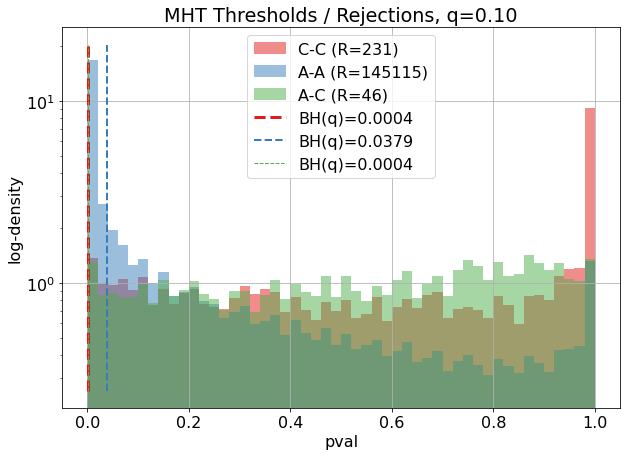

In [22]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 1, figsize=(10, 7));
colors = plt.cm.Set1.colors

nbins = 50
q = 0.1

zip_name_df = tuple(zip(
    ["C-C", "A-A", "A-C"],
    [df_pvals_cc, df_pvals_aa, df_pvals_ac]
))

for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df['pval'])
    num_rejections = np.sum(df['pval'] < thresh)
    df.hist(
        'pval',
        bins=nbins,
        ax=ax,
        density=True,
        log=True,
        color=colors[i],
        alpha=0.5,
        label=f"{name} (R={num_rejections})",
    )
    m = len(df['pval'])
    print(f"{name=}, {m=}, %rejected={num_rejections/m*100:.2f}")
    
    
ymin, ymax = ax.get_ylim()
for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df['pval'])
    ax.vlines(
        thresh,
        ymin, ymax,
        linewidths=1*(len(zip_name_df)-i),
        linestyles="dashed",
        colors=colors[i],
        label=f"BH(q)={thresh:.04f}"
    )

ax.set_title(f"MHT Thresholds / Rejections, {q=:.2f}")
ax.set_ylabel("log-density")
ax.set_xlabel("pval")
ax.legend();
fig.savefig("out/pointwise_pvals_hist.png", bbox_inches="tight", dpi=150)